# Omission LFP Analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import glob
from collections import defaultdict
import re

In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import itertools
from scipy.stats import linregress

In [4]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [5]:
from statsmodels.tsa.stattools import grangercausalitytests


## Inputs & Data

Explanation of each input and where it comes from.

In [6]:
# Define your keywords
KEYWORD_TOP = '_trial_'
KEYWORD_BOTTOM = '_baseline_'

In [7]:
GROUPING = "all"
# GROUPING = "velocity_parsed"

In [8]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

In [9]:
BBOX_TO_ANCHOR=(1.5, 0.9)
LOC='upper right'

In [10]:
ALL_BANDS = ["theta", "beta", "gamma"]
BAND_TO_FREQ = {"theta": {"low_freq": 4, "high_freq": 12}, "beta": {"low_freq": 13, "high_freq": 30}, "gamma": {"low_freq": 30, "high_freq": 70}}

In [11]:
# variables for LFP extraction
FREQ_MIN=0.5
FREQ_MAX=300
NOTCH_FREQ=60
ORIGINAL_SAMPLE_RATE = 20000
RESAMPLE_RATE=1000
TRIAL_DURATION=10

In [12]:
INPUT_VARIABLE = 1

TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5


TRIAL_TIME_STAMP_DURATION = 1000*10

In [13]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5cm/s+"}

In [14]:
NUM_LINES = 3

In [15]:
BASELINE_OUTCOME_TO_COLOR = {
'lose': "red",
'lose_trial': "red",
'lose_baseline': "hotpink",

'omission': "orange",
'omission_trial': "orange",
'omission_baseline': "navajowhite",

'rewarded': "green",
'rewarded_trial': "green",
'rewarded_baseline': "lightgreen",

'win': "blue",
'win_trial': "blue",
'win_baseline': "lightblue"}

In [16]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [17]:
CHANNEL_MAPPING_DF = pd.read_excel("../../data/channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("../../data/rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [18]:
def standardize_col_name(col_name, keywords, replacement="_"):
    """
    Standardize the column name by removing specified keywords.

    Parameters:
    col_name (str): The original column name.
    keywords (list of str): A list of keywords to remove from the column name.

    Returns:
    str: The standardized column name.
    """
    for keyword in keywords:
        col_name = col_name.replace(keyword, replacement)
    # Replace any double underscores possibly created and strip leading/trailing underscores
    col_name = col_name.replace('__', '_').strip('_')
    return col_name

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

In [19]:
def generate_pairs(lst):
    pairs = []
    n = len(lst)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((lst[i], lst[j]))
    return pairs

In [20]:
def nested_dict():
    return defaultdict(dict)

triple_nested_dict = defaultdict(nested_dict)

In [21]:
# @title Plotting Functions

def see_neurons(A, ax):
    """
    Visualizes the connectivity matrix.

    Args:
        A (np.ndarray): the connectivity matrix of shape (n_neurons, n_neurons)
        ax (plt.axis): the matplotlib axis to display on

    Returns:
        Nothing, but visualizes A.
    """
    A = A.T  # make up for opposite connectivity
    n = len(A)
    ax.set_aspect('equal')
    thetas = np.linspace(0, np.pi * 2, n,endpoint=False)
    x, y = np.cos(thetas), np.sin(thetas),
    ax.scatter(x, y, c='k',s=150)
    A = A / A.max()
    for i in range(n):
        for j in range(n):
            if A[i, j] > 0:
                ax.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='k', alpha=A[i, j], head_width=.15,
                        width = A[i,j] / 25, shape='right', length_includes_head=True)
    ax.axis('off')

def plot_neural_activity(X):
  """Plot first 10 timesteps of neural activity

  Args:
    X (ndarray): neural activity (n_neurons by timesteps)

  """
  f, ax = plt.subplots()
  im = ax.imshow(X[:, :10], aspect='auto')
  divider = make_axes_locatable(ax)
  cax1 = divider.append_axes("right", size="5%", pad=0.15)
  plt.colorbar(im, cax=cax1)
  ax.set(xlabel='Timestep', ylabel='Neuron', title='Simulated Neural Activity')


def compare_granger_connectivity(A, reject_null, selected_neuron):
  """Plot granger connectivity vs true

  Args:
    A (ndarray): true connectivity (n_neurons by n_neurons)
    reject_null (list): outcome of granger causality, length n_neurons
    selecte_neuron (int): the neuron we are plotting connectivity from

  """
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  im = axs[0].imshow(A[:, [selected_neuron]], cmap='coolwarm', aspect='auto')
  plt.colorbar(im, ax = axs[0])
  axs[0].set_xticks([0])
  axs[0].set_xticklabels([selected_neuron])
  axs[0].title.set_text("True connectivity for neuron {}".format(selected_neuron))

  im = axs[1].imshow(np.array([reject_null]).transpose(), cmap='coolwarm', aspect='auto')
  plt.colorbar(im, ax=axs[1])
  axs[1].set_xticks([0])
  axs[1].set_xticklabels([selected_neuron])
  axs[1].title.set_text("Granger causality connectivity for neuron {}".format(selected_neuron))


def plot_performance_vs_eta(etas, corr_data):
  """ Plot IV estimation performance as a function of instrument strength

    Args:
      etas (list): list of instrument strengths
      corr_data (ndarray): n_trials x len(etas) array where each element is the correlation
        between true and estimated connectivity matries for that trial and
        instrument strength

  """
  corr_mean = corr_data.mean(axis=0)
  corr_std = corr_data.std(axis=0)

  plt.plot(etas, corr_mean)
  plt.fill_between(etas,
              corr_mean - corr_std,
              corr_mean + corr_std,
              alpha=.2)
  plt.xlim([etas[0], etas[-1]])
  plt.title("IV performance as a function of instrument strength")
  plt.ylabel("Correlation b.t. IV and true connectivity")
  plt.xlabel("Strength of instrument (eta)")
  plt.show()

In [22]:
# @title Helper Functions

def sigmoid(x):
    """
    Compute sigmoid nonlinearity element-wise on x.

    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with sigmoid nonlinearity applied
    """
    return 1 / (1 + np.exp(-x))


def logit(x):
    """

    Applies the logit (inverse sigmoid) transformation

    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with logit nonlinearity applied
    """
    return np.log(x/(1-x))


def create_connectivity(n_neurons, random_state=42, p=0.9):
    """
    Generate our nxn causal connectivity matrix.

    Args:
        n_neurons (int): the number of neurons in our system.
        random_state (int): random seed for reproducibility

    Returns:
        A (np.ndarray): our 0.1 sparse connectivity matrix
    """
    np.random.seed(random_state)
    A_0 = np.random.choice([0, 1], size=(n_neurons, n_neurons), p=[p, 1 - p])

    # set the timescale of the dynamical system to about 100 steps
    _, s_vals, _ = np.linalg.svd(A_0)
    A = A_0 / (1.01 * s_vals[0])

    # _, s_val_test, _ = np.linalg.svd(A)
    # assert s_val_test[0] < 1, "largest singular value >= 1"

    return A


def simulate_neurons(A, timesteps, random_state=42):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps.

    Args:
        A (np.array): the connectivity matrix
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): random seed for reproducibility

    Returns:
        - X has shape (n_neurons, timeteps).
    """
    np.random.seed(random_state)

    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps - 1):
        # solution
        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))
        X[:, t + 1] = sigmoid(A.dot(X[:, t]) + epsilon)

        assert epsilon.shape == (n_neurons,)
    return X


def get_sys_corr(n_neurons, timesteps, random_state=42, neuron_idx=None):
    """
    A wrapper function for our correlation calculations between A and R.

    Args:
        n_neurons (int): the number of neurons in our system.
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): seed for reproducibility
        neuron_idx (int): optionally provide a neuron idx to slice out

    Returns:
        A single float correlation value representing the similarity between A and R
    """

    A = create_connectivity(n_neurons, random_state)
    X = simulate_neurons(A, timesteps)

    R = correlation_for_all_neurons(X)

    return np.corrcoef(A.flatten(), R.flatten())[0, 1]


def correlation_for_all_neurons(X):
  """Computes the connectivity matrix for the all neurons using correlations

    Args:
        X: the matrix of activities

    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
  """
  n_neurons = len(X)
  S = np.concatenate([X[:, 1:], X[:, :-1]], axis=0)
  R = np.corrcoef(S)[:n_neurons, n_neurons:]
  return R


def print_corr(v1, v2, corrs, idx_dict):
    """Helper function for formatting print statements for correlations"""
    text_dict = {'Z':'taxes', 'T':'# cigarettes', 'C':'SES status', 'Y':'birth weight'}
    print("Correlation between {} and {} ({} and {}): {:.3f}".format(v1, v2, text_dict[v1], text_dict[v2], corrs[idx_dict[v1], idx_dict[v2]]))


def get_regression_estimate(X, neuron_idx=None):
    """
    Estimates the connectivity matrix using lasso regression.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int): optionally provide a neuron idx to compute connectivity for
    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    n_neurons = X.shape[0]

    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    if neuron_idx is None:
        Y = X[:, 1:].transpose()
    else:
        Y = X[[neuron_idx], 1:].transpose()

    # apply inverse sigmoid transformation
    Y = logit(Y)

    # fit multioutput regression
    regression = MultiOutputRegressor(Lasso(fit_intercept=False, alpha=0.01), n_jobs=-1)

    regression.fit(W,Y)

    if neuron_idx is None:
        V = np.zeros((n_neurons, n_neurons))
        for i, estimator in enumerate(regression.estimators_):
            V[i, :] = estimator.coef_
    else:
        V = regression.estimators_[0].coef_

    return V


def get_regression_corr(n_neurons, timesteps, random_state, observed_ratio, regression_args, neuron_idx=None):
    """
    A wrapper function for our correlation calculations between A and the V estimated
    from regression.

    Args:
        n_neurons (int): the number of neurons in our system.
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): seed for reproducibility
        observed_ratio (float): the proportion of n_neurons observed, must be betweem 0 and 1.
        regression_args (dict): dictionary of lasso regression arguments and hyperparameters
        neuron_idx (int): optionally provide a neuron idx to compute connectivity for

    Returns:
        A single float correlation value representing the similarity between A and R
    """
    assert (observed_ratio > 0) and (observed_ratio <= 1)

    A = create_connectivity(n_neurons, random_state)
    X = simulate_neurons(A, timesteps)

    sel_idx = np.clip(int(n_neurons*observed_ratio), 1, n_neurons)

    sel_X = X[:sel_idx, :]
    sel_A = A[:sel_idx, :sel_idx]

    sel_V = get_regression_estimate(sel_X, neuron_idx=neuron_idx)
    if neuron_idx is None:
        return np.corrcoef(sel_A.flatten(), sel_V.flatten())[1, 0]
    else:
        return np.corrcoef(sel_A[neuron_idx, :], sel_V)[1, 0]


def get_regression_estimate_full_connectivity(X):
    """
    Estimates the connectivity matrix using lasso regression.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int): optionally provide a neuron idx to compute connectivity for
    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    n_neurons = X.shape[0]

    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    Y = X[:, 1:].transpose()

    # apply inverse sigmoid transformation
    Y = logit(Y)

    # fit multioutput regression
    reg = MultiOutputRegressor(Lasso(fit_intercept=False, alpha=0.01, max_iter=200), n_jobs=-1)
    reg.fit(W, Y)

    V = np.zeros((n_neurons, n_neurons))
    for i, estimator in enumerate(reg.estimators_):
        V[i, :] = estimator.coef_

    return V


def get_regression_corr_full_connectivity(n_neurons, A, X, observed_ratio, regression_args):
    """
    A wrapper function for our correlation calculations between A and the V estimated
    from regression.

    Args:
        n_neurons (int): number of neurons
        A (np.ndarray): connectivity matrix
        X (np.ndarray): dynamical system
        observed_ratio (float): the proportion of n_neurons observed, must be betweem 0 and 1.
        regression_args (dict): dictionary of lasso regression arguments and hyperparameters

    Returns:
        A single float correlation value representing the similarity between A and R
    """
    assert (observed_ratio > 0) and (observed_ratio <= 1)

    sel_idx = np.clip(int(n_neurons*observed_ratio), 1, n_neurons)

    sel_X = X[:sel_idx, :]
    sel_A = A[:sel_idx, :sel_idx]

    sel_V = get_regression_estimate_full_connectivity(sel_X)
    return np.corrcoef(sel_A.flatten(), sel_V.flatten())[1,0], sel_V

In [52]:
# to_remove solution
def get_granger_causality(X, selected_neuron, alpha=0.05):
  """
  Estimates the lag-1 granger causality of the given neuron on the other neurons in the system.

  Args:
      X (np.ndarray): the matrix holding our dynamical system of shape (n_neurons, timesteps)
      selected_neuron (int): the index of the neuron we want to estimate granger causality for
      alpha (float): Bonferroni multiple comparisons correction

  Returns:
      A tuple (reject_null, p_vals)
      reject_null (list): a binary list of length n_neurons whether the null was
          rejected for the selected neuron granger causing the other neurons
      p_vals (list): a list of the p-values for the corresponding Granger causality tests
  """
  n_neurons = X.shape[0]
  max_lag = 1

  reject_null = []
  p_vals = []

  for target_neuron in range(n_neurons):
    ts_data = X[[target_neuron, selected_neuron], :].transpose()
    return ts_data
    res = grangercausalitytests(ts_data, maxlag=max_lag, verbose=False)

    # Gets the p-value for the log-ratio test
    pval = res[1][0]['lrtest'][1]

    p_vals.append(pval)
    reject_null.append(int(pval < alpha))

  return reject_null, p_vals


# Set up small system
n_neurons = 6
timesteps = 5000
random_state = 42
selected_neuron = 1

A = create_connectivity(n_neurons, random_state)
X = simulate_neurons(A, timesteps, random_state)

# Estimate Granger causality
reject_null, p_vals = get_granger_causality(X, selected_neuron)

# Visualize
compare_granger_connectivity(A, reject_null, selected_neuron)

ValueError: too many values to unpack (expected 2)

In [68]:
def get_single_granger_causality(arr1, arr2, alpha=0.05):
    """
    Estimates the lag-1 granger causality of the given neuron on the other neurons in the system.
    
    Args:
      X (np.ndarray): the matrix holding our dynamical system of shape (n_neurons, timesteps)
      selected_neuron (int): the index of the neuron we want to estimate granger causality for
      alpha (float): Bonferroni multiple comparisons correction
    
    Returns:
      A tuple (reject_null, p_vals)
      reject_null (list): a binary list of length n_neurons whether the null was
          rejected for the selected neuron granger causing the other neurons
      p_vals (list): a list of the p-values for the corresponding Granger causality tests
    """
    try:
        max_lag = 1
          
        X = np.array([arr1, arr2]).T
        res = grangercausalitytests(X, maxlag=max_lag, verbose=False)
        
        # Gets the p-value for the log-ratio test
        pval = res[1][0]['lrtest'][1]
        return res
        return int(pval < alpha), pval
    except:
        return np.nan

In [73]:
get_single_granger_causality(arr1=MERGED_LFP_AND_SLEAP.iloc[0][region_1], arr2=MERGED_LFP_AND_SLEAP.iloc[0][region_2])[1][0]

{'ssr_ftest': (3.8849343384582355, 0.048748711079005136, 9996.0, 1),
 'ssr_chi2test': (3.8861002851384447, 0.04868735057335274, 1),
 'lrtest': (3.8853453164556413, 0.04870924477501359, 1),
 'params_ftest': (3.884934338458295, 0.048748711079005136, 9996.0, 1.0)}

In [54]:
get_granger_causality(X, selected_neuron).shape

(5000, 2)

In [51]:
X.shape

(6, 5000)

## Processing

In [24]:
raise ValueError()

ValueError: 

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [ ]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

## Calculating average power per band

In [33]:
MERGED_LFP_AND_SLEAP = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")

In [34]:
for col in MERGED_LFP_AND_SLEAP.columns:
    print(col)

time
recording_dir
recording_file
time_stamp_index
video_file
video_frame
video_number
subject_info
competition_closeness
video_name
all_subjects
current_subject
trial_outcome
lfp_index
baseline_lfp_timestamp_range
trial_lfp_timestamp_range
baseline_ephys_timestamp_range
trial_ephys_timestamp_range
baseline_videoframe_range
trial_videoframe_range
trial_number
Cohort
spike_interface_mPFC
spike_interface_vHPC
spike_interface_BLA
spike_interface_LH
spike_interface_MD
mPFC_baseline_lfp_trace
mPFC_trial_lfp_trace
vHPC_baseline_lfp_trace
vHPC_trial_lfp_trace
BLA_baseline_lfp_trace
BLA_trial_lfp_trace
LH_baseline_lfp_trace
LH_trial_lfp_trace
MD_baseline_lfp_trace
MD_trial_lfp_trace


In [35]:
chunk_averaged_power_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "trial_lfp_trace" in col]

In [36]:
chunk_averaged_power_columns

['mPFC_trial_lfp_trace',
 'vHPC_trial_lfp_trace',
 'BLA_trial_lfp_trace',
 'LH_trial_lfp_trace',
 'MD_trial_lfp_trace']

In [37]:
for region_1 in chunk_averaged_power_columns:
    for region_2 in chunk_averaged_power_columns:
        

IndentationError: expected an indented block (1240108011.py, line 3)

In [39]:
from itertools import permutations 

In [42]:
MERGED_LFP_AND_SLEAP.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'vHPC_baseline_lfp_trace', 'vHPC_trial_lfp_trace',
       'BLA_baseline_lfp_trace', 'BLA_trial_lfp_trace',
       'LH_baseline_lfp_trace', 'LH_trial_lfp_trace', 'MD_baseline_lfp_trace',
       'MD_trial_lfp_trace'],
      dtype='object')

In [56]:
np.array([MERGED_LFP_AND_SLEAP.iloc[0][region_1], MERGED_LFP_AND_SLEAP.iloc[0][region_2]]).T.shape

(10000, 2)

In [66]:
for region_1, region_2 in permutations(chunk_averaged_power_columns, 2):
    pair_base_name = "{}_{}".format(region_1.split("_")[0], region_2.split("_")[0],)
    print(pair_base_name)
    try:
        
        # granger_value = grangercausalitytests(MERGED_LFP_AND_SLEAP[[region_1, region_2]], maxlag=[3])
        MERGED_LFP_AND_SLEAP["{}_granger".format(pair_base_name)] = MERGED_LFP_AND_SLEAP.apply(lambda row: get_single_granger_causality(arr1=row[region_1], arr2=row[region_2]), axis=1)
        print()
    except Exception as e: 
        print(e)
    break

mPFC_vHPC



In [67]:
MERGED_LFP_AND_SLEAP

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,mPFC_trial_lfp_trace,vHPC_baseline_lfp_trace,vHPC_trial_lfp_trace,BLA_baseline_lfp_trace,BLA_trial_lfp_trace,LH_baseline_lfp_trace,LH_trial_lfp_trace,MD_baseline_lfp_trace,MD_trial_lfp_trace,mPFC_vHPC_granger
0,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[0.6927297, 0.96389693, 0.7884358, -0.04101689...","[-0.06969439, -0.09568214, -0.05315674, 0.1571...","[1.5864334, 1.5710771, 1.5970649, 1.2155175, 0...","[2.0367627, 2.1163385, 2.1618104, 2.2679114, 2...","[0.3164087, 0.36377528, 0.18757163, -0.5020857...","[3.1382985, 3.2319791, 3.2788196, 3.2881875, 3...","[0.8118982, 1.2209699, 0.87435186, -0.4028264,...","[1.3934726, 1.494771, 1.764077, 1.828315, 1.68...","[-0.9783956, -0.86721426, -0.7288553, -1.40582...","(1, 0.04870924477501359)"
1,7910662,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[1.0732753, 0.7246318, 0.7633699, 0.3782669, -...","[0.31539667, 0.23152715, 0.29767776, 0.4217101...","[0.03543783, -0.27641505, -0.40044746, -0.6638...","[0.3107247, 0.14209972, -0.05873455, -0.331566...","[0.026525281, -0.04547191, 0.11936376, -0.4092...","[-1.180375, -1.2959143, -1.3771042, -1.458294,...","[0.9492963, 0.46840277, 0.6713773, 0.043717593...","[-0.14577106, -0.16059524, 0.027177656, 0.1680...","[1.6281886, 1.349, 1.4675934, 0.9487473, -0.21...","(0, 0.2948044219582392)"
2,9710660,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[0.28711826, 0.84996116, 1.0960625, 0.8226166,...","[-1.2556804, -1.2580429, -1.3312811, -1.118654...","[0.060244307, 0.4748669, 0.7654571, 0.6591436,...","[-1.9912907, -1.9041362, -1.9325562, -1.542255...","[0.69344664, 1.4001559, 1.7582471, 1.4304705, ...","[-0.19985186, -0.074944444, -0.18423842, -0.13...","[-0.59643286, 0.27167362, 0.6901134, 0.4371759...","[-0.32119048, -0.52872896, -0.96851283, -0.753...","[0.096357144, 0.88450915, 1.2131118, 0.8943919...","(0, 0.1654044864439619)"
3,11310658,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,20221202_134600_omission_and_competition_subje...,...,"[2.376701, 2.3015034, 1.7796774, 0.9411098, 0....","[0.16655779, 0.42879772, 0.66268736, 0.6934002...","[-1.8427671, -2.303459, -2.6802812, -3.060647,...","[-1.2637402, -1.0382752, -0.82986236, -0.74649...","[2.6771586, 2.3929594, 2.209177, 1.9761335, 1....","[-2.538743, -2.1983705, -1.8673657, -1.7143542...","[2.8447661, 2.3045416, 1.5301157, 0.96490973, ...","[-2.7647088, -2.5546997, -2.3051593, -2.055619...","[2.087738, 1.7418406, 1.1266373, 0.45954946, 0...","(0, 0.6618272625435087)"
4,12810657,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-0.043295607, 0.73602533, 0.31674156, 0.07747...","[-0.31421542, 0.19727057, 0.4453354, 0.3744597...","[0.21617076, 0.8221576, 0.58236164, 0.43116024...","[-2.1352851, -2.0576038, -2.0822346, -2.140969...","[-0.18188764, 0.113679774, -0.66123736, -0.935...","[-2.1671436, -1.4832754, -1.0554676, -1.130412...","[0.5339792, 1.5113796, 0.57145137, -0.02810416...","[-2.0111465, -1.714663, 

In [75]:
for region_1, region_2 in permutations(chunk_averaged_power_columns, 2):
    pair_base_name = "{}_{}".format(region_1.strip("trace").strip("_"), region_2.strip("trace").strip("_"))
    print(pair_base_name)
    try:
        
        # granger_value = grangercausalitytests(MERGED_LFP_AND_SLEAP[[region_1, region_2]], maxlag=[3])
        MERGED_LFP_AND_SLEAP["{}_granger".format(pair_base_name)] = MERGED_LFP_AND_SLEAP.apply(lambda row: grangercausalitytests(np.array([row[region_1], row[region_2]]).T, maxlag=1), axis=1)
        print()
    except Exception as e: 
        print(e)
    break

mPFC_trial_lfp_vHPC_trial_lfp

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8849  , p=0.0487  , df_denom=9996, df_num=1
ssr based chi2 test:   chi2=3.8861  , p=0.0487  , df=1
likelihood ratio test: chi2=3.8853  , p=0.0487  , df=1
parameter F test:         F=3.8849  , p=0.0487  , df_denom=9996, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0973  , p=0.2949  , df_denom=9996, df_num=1
ssr based chi2 test:   chi2=1.0976  , p=0.2948  , df=1
likelihood ratio test: chi2=1.0975  , p=0.2948  , df=1
parameter F test:         F=1.0973  , p=0.2949  , df_denom=9996, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9237  , p=0.1655  , df_denom=9996, df_num=1
ssr based chi2 test:   chi2=1.9243  , p=0.1654  , df=1
likelihood ratio test: chi2=1.9241  , p=0.1654  , df=1
parameter F test:         F=1.9237  , p=0.1655  , df_denom=9996, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F 

## Power correlation between brain regions calculation

- Combining the trial/baseline and outcome label for coloring

In [ ]:
MERGED_LFP_AND_SLEAP["outcome_and_trial_or_baseline"] = MERGED_LFP_AND_SLEAP.apply(lambda x: "_".join([x["trial_outcome"], x["trial_or_baseline"]]), axis=1)

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests



In [ ]:
MERGED_LFP_AND_SLEAP.columns

In [ ]:
trace_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "trace" in col]

In [ ]:
trace_columns

In [ ]:
brain_region_pairs = generate_pairs(trace_columns)

In [ ]:
brain_region_pairs

In [ ]:
grangercausalitytests(df[['column1', 'column2']], maxlag=[3])

In [ ]:
MERGED_LFP_AND_SLEAP[region_1].iloc[0]

In [ ]:
for region_1, region_2 in brain_region_pairs:
    pair_base_name = "{}_{}".format(region_1.strip("trace").strip("_"), region_2.strip("trace").strip("_"))
    print(pair_base_name)
    try:
        
        # granger_value = grangercausalitytests(MERGED_LFP_AND_SLEAP[[region_1, region_2]], maxlag=[3])
        MERGED_LFP_AND_SLEAP["{}_granger".format(pair_base_name)] = MERGED_LFP_AND_SLEAP.apply(lambda row: grangercausalitytests(np.array([row[region_1], row[region_2]]).T, maxlag=[3]), axis=1)
        print()
    except Exception as e: 
        print(e)
    break

In [ ]:
MERGED_LFP_AND_SLEAP[""]

In [ ]:
MERGED_LFP_AND_SLEAP

In [ ]:
granger_value

- Filtering out the outliers

In [ ]:
band_to_power_correlation = defaultdict(dict)
for band in ALL_BANDS:
    # Getting all the pairs of brain regions
    band_averaged_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "averaged_{}".format(band) in col]
    band_to_power_correlation[band]["brain_region_pairs"] = generate_pairs(band_averaged_columns)
    print(band_to_power_correlation[band]["brain_region_pairs"])

    # Removing rows that are outliers
    filtered_df = MERGED_LFP_AND_SLEAP.copy()
    
    for col in band_averaged_columns:
        # filtered_df = filtered_df[filtered_df[col] <= 3]
        # Assuming data is a 1D numpy array
        Q1 = np.percentile(filtered_df[col], 25)
        Q3 = np.percentile(filtered_df[col], 75)
        IQR = Q3 - Q1
        band_to_power_correlation[band]["outlier_removed_df"] = filtered_df[(filtered_df[col] >= Q1 - 1.5 * IQR) & (filtered_df[col] <= Q3 + 1.5 * IQR)]


    
    # Getting the mean and standard deviation
    

In [ ]:
band_to_power_correlation = defaultdict(dict)
for band in ALL_BANDS:
    # Getting all the pairs of brain regions
    band_averaged_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "averaged_{}".format(band) in col]
    band_to_power_correlation[band]["brain_region_pairs"] = generate_pairs(band_averaged_columns)
    print(band_to_power_correlation[band]["brain_region_pairs"])

    # Removing rows that are outliers
    filtered_df = MERGED_LFP_AND_SLEAP.copy()
    
    for col in band_averaged_columns:
        # filtered_df = filtered_df[filtered_df[col] <= 3]
        # Assuming data is a 1D numpy array
        Q1 = np.percentile(filtered_df[col], 25)
        Q3 = np.percentile(filtered_df[col], 75)
        IQR = Q3 - Q1
        filtered_df = filtered_df[(filtered_df[col] >= Q1 - 1.5 * IQR) & (filtered_df[col] <= Q3 + 1.5 * IQR)]
    band_to_power_correlation[band]["outlier_removed_df"] = filtered_df

In [ ]:
MERGED_LFP_AND_SLEAP.shape

In [ ]:
band_to_power_correlation[band]["outlier_removed_df"].shape

- Plotting all of the conditions

In [ ]:
for band in ALL_BANDS:
    for region_1, region_2 in band_to_power_correlation[band]["brain_region_pairs"]:
        region_1_basename = region_1.split("_")[0]
        region_2_basename = region_2.split("_")[0]
        x = band_to_power_correlation[band]["outlier_removed_df"][region_1]
        y = band_to_power_correlation[band]["outlier_removed_df"][region_2]
        
        # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        
        # Create a line of best fit using the slope and intercept
        line = slope * x + intercept
        
        # Create scatter plot
        sns.scatterplot(x=x, y=y, data=band_to_power_correlation[band]["outlier_removed_df"], hue='outcome_and_trial_or_baseline', palette=BASELINE_OUTCOME_TO_COLOR)
        
        # Plot line of best fit
        plt.plot(x, line, color='red')
        
        # Add R² value to the plot
        plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
        
        # Add labels and legend
        plt.title("Power correlation of Z-scored {} band LFP: {} and {}".format(band, region_2_basename, region_1_basename))
        plt.xlabel('{} {} power of Z-scored LFP'.format(band, region_1_basename))
        plt.ylabel('{} {} power of Z-scored LFP'.format(band, region_2_basename))
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig("./proc/power_correlation/zscored/{}/all_condition_{}_{}_power_correlation_of_zscored_{}_lfp.png".format(band, region_1_basename, region_2_basename, band))
        # Display the plot
        plt.show()




In [ ]:
raise ValueError()

In [ ]:
MERGED_LFP_AND_SLEAP = filtered_df

In [ ]:
MERGED_LFP_AND_SLEAP["trial_outcome"].unique()

In [ ]:
MERGED_LFP_AND_SLEAP["trial_or_baseline"]

In [ ]:
for band in ALL_BANDS:
    band_df = band_to_power_correlation[band]["outlier_removed_df"]
    band_to_power_correlation[band]["region_pair_to_outcome_to_r2"] = defaultdict(nested_dict)
    for outcome in band_df["trial_outcome"].unique():
        outcome_df = band_df[band_df["trial_outcome"] == outcome]
        for region_1, region_2 in brain_region_pairs:
            region_1_basename = region_1.split("_")[0]
            region_2_basename = region_2.split("_")[0]
            
            x = outcome_df[region_1]
            y = outcome_df[region_2]
            
            # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            # Square the r value to get the r squared value
            r2_value = r_value**2
            band_to_power_correlation[band]["region_pair_to_outcome_to_r2"]["{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])][outcome]["r"] = r_value
            band_to_power_correlation[band]["region_pair_to_outcome_to_r2"]["{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])][outcome]["std"] = std_err
            
            # Create a line of best fit using the slope and intercept
            line = slope * x + intercept
            
            # Create scatter plot
            sns.scatterplot(x=x, y=y, data=outcome_df, hue='outcome_and_trial_or_baseline', palette=BASELINE_OUTCOME_TO_COLOR, style='outcome_and_trial_or_baseline', markers=['^', 'o'])
            
            # Plot line of best fit
            plt.plot(x, line, color='red')
            
            # Add R² value to the plot
            plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
            
            # Add labels and legend
            plt.title("Power Correlation of Z-scored {} LFP: {} and {}".format(band, region_2_basename, region_1_basename))
            plt.xlabel('{} {} Power of Z-scored LFP'.format(region_1_basename, band))
            plt.ylabel('{} {} Power of Z-scored LFP'.format(region_2_basename, band))
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.savefig("./proc/power_correlation/zscored/{}/{}_{}_{}_power_correlation_of_zscored_{}_lfp.png".format(band, outcome, region_1_basename, region_2_basename, band))
            # Display the plot
            plt.show()

In [ ]:
for band in ALL_BANDS:
    # Convert the nested dictionary to a DataFrame
    data = []
    for group_name, group_data in band_to_power_correlation[band]['region_pair_to_outcome_to_r2'].items():
        for bar_name, bar_dict in group_data.items():
            data.append({"Group": group_name, "Bar": bar_name, "r": bar_dict["r"], "std": bar_dict["std"]})
    df = pd.DataFrame(data)
    
    # Create the bar plot using seaborn
    # sns.catplot(
    #     data=df, 
    #     x='Group', 
    #     y='r2', 
    #     hue='Bar', 
    #     kind='bar', 
    #     height=4, 
    #     aspect=2,
    #     legend=False,
    #     # yerr=df['std'].values,  # This line adds the SEM bars
    #     # capsize=0.1  # This line adds caps on the error bars
    # )
    
    # Create barplot
    ax = sns.barplot(x='Group', y='r', hue='Bar', data=df, ci=None)
    
    # Adding error bars
    groups = df['Group'].unique()
    bars_per_group = df['Bar'].nunique()
    bar_width = 0.8 / bars_per_group
    x_positions = []
    
    for i, group in enumerate(groups):
        num_bars = df[df['Group'] == group].shape[0]
        group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
        x_positions.extend(group_positions)
    
    for i, (r2, sem) in enumerate(zip(df['r'], df['std'])):
        plt.errorbar(x_positions[i], r2, yerr=sem, fmt='none', color='black', capsize=5)
    
    
    plt.xticks(rotation=90)
    plt.xlabel("Brain region pairs")
    plt.ylabel("Power correlation r")
    plt.legend(title="Trial Conditions")
    plt.title("{} Power correlations".format(band))
    plt.tight_layout()
    plt.grid()
    
    plt.savefig("./proc/power_correlation/zscored/all_zscored_{}_lfp_power_correlation.png".format(band))
    # Show the plot
    plt.show()

In [ ]:

# Convert the nested dictionary to a DataFrame
data = []
for group_name, group_data in region_pair_to_outcome_to_r2.items():
    for bar_name, bar_dict in group_data.items():
        data.append({"Group": group_name, "Bar": bar_name, "r": bar_dict["r"], "std": bar_dict["std"]})
df = pd.DataFrame(data)

# Create the bar plot using seaborn
# sns.catplot(
#     data=df, 
#     x='Group', 
#     y='r2', 
#     hue='Bar', 
#     kind='bar', 
#     height=4, 
#     aspect=2,
#     legend=False,
#     # yerr=df['std'].values,  # This line adds the SEM bars
#     # capsize=0.1  # This line adds caps on the error bars
# )

# Create barplot
ax = sns.barplot(x='Group', y='r', hue='Bar', data=df, ci=None)

# Adding error bars
groups = df['Group'].unique()
bars_per_group = df['Bar'].nunique()
bar_width = 0.8 / bars_per_group
x_positions = []

for i, group in enumerate(groups):
    num_bars = df[df['Group'] == group].shape[0]
    group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
    x_positions.extend(group_positions)

for i, (r2, sem) in enumerate(zip(df['r'], df['std'])):
    plt.errorbar(x_positions[i], r2, yerr=sem, fmt='none', color='black', capsize=5)


plt.xticks(rotation=90)
plt.xlabel("Brain region pairs")
plt.ylabel("Power correlation r")
plt.legend(title="Trial Conditions")
plt.title("Power correlations")
plt.tight_layout()
plt.grid()

plt.savefig("./proc/power_correlation/zscored/all_zscored_lfp_power_correlation.png")
# Show the plot
plt.show()

In [83]:
bars

<BarContainer object of 3 artists>

In [86]:
import statannot
statannot.add_stat_annotation(
    ax,
    data=df,
    x=x,
    y=y,
    hue=hue,
    box_pairs=[
        (("Biscoe", "Male"), ("Torgersen", "Female")),
        (("Dream", "Male"), ("Dream", "Female")),
    ],
    test="t-test_ind",
    text_format="star",
    loc="outside",
)

ModuleNotFoundError: No module named 'statannot'

In [97]:
x_coords

[0.0, 1.0, 2.0]

TypeError: cannot convert dictionary update sequence element #0 to a sequence

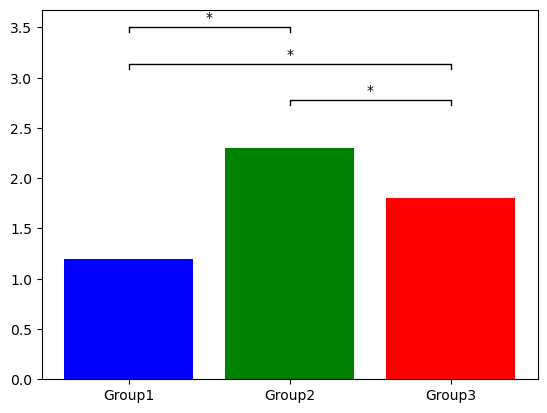

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
groups = ['Group1', 'Group2', 'Group3']
values = [1.2, 2.3, 1.8]

# Dictionary holding the results of your statistical comparisons
# Keys are tuples indicating the groups being compared; values are the corresponding p-values
stats_dict = {('Group1', 'Group2'): 0.04, ('Group1', 'Group3'): 0.01, ('Group2', 'Group3'): 0.01}

# Thresholds for significance levels
alpha = 0.05  # usually 0.05
alpha_strong = 0.01  # example value

# Create bar plot
fig, ax = plt.subplots()
bars = plt.bar(groups, values, color=['blue', 'green', 'red'])

# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom

# Retrieve x-coordinates of the bars
x_coords = [bar.get_x() + bar.get_width() / 2.0 for bar in bars]  # get_x() retrieves the left coordinate, we adjust by half the width to get the center
group_to_x_coord = {group: x_coord for group, x_coord in zip(groups, x_coords)}


# Significance bars
for i, (key, value) in enumerate(stats_dict.items()):
    # Significance level
    p = value
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        continue
    
    # Columns corresponding to the datasets of interest
    x1 = key[0]
    x2 = key[1]
    # What level is this bar among the bars above the plot?
    level = len(stats_dict) - i
    # Plot the bar
    bar_height = (y_range * 0.15 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    
    text_height = bar_height + (y_range * 0.01)
    plt.text((group_to_x_coord[x1] + group_to_x_coord[x2]) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

NameError: name 'y_range' is not defined

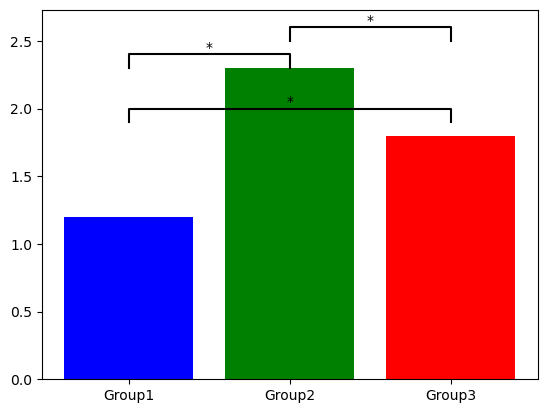

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
groups = ['Group1', 'Group2', 'Group3']
values = [1.2, 2.3, 1.8]

# Dictionary holding the results of your statistical comparisons
# Keys are tuples indicating the groups being compared; values are the corresponding p-values
stats_dict = {('Group1', 'Group2'): 0.04, ('Group1', 'Group3'): 0.01, ('Group2', 'Group3'): 0.01}

# Thresholds for significance levels
alpha = 0.05  # usually 0.05
alpha_strong = 0.01  # example value

# Create bar plot
fig, ax = plt.subplots()
bars = plt.bar(groups, values, color=['blue', 'green', 'red'])

# Function to draw significance bars
def draw_significance_bar(ax, x1, x2, y, height, text, offset):
    ax.plot([x1, x1, x2, x2], [y + offset, y + height + offset, y + height + offset, y + offset], lw=1.5, c='black')
    ax.text((x1 + x2) * .5, y + height + offset, text, ha='center', va='bottom', color='black')

# Height of the small vertical ticks and offset for multiple comparisons
tick_height = 0.1
offset_step = 0.1  # How much to offset each additional line

# Track the current offset
current_offsets = {group: 0 for group in groups}

# Check each comparison
for comparison, p_value in stats_dict.items():
    # Determine the index of the groups
    index_1 = groups.index(comparison[0])
    index_2 = groups.index(comparison[1])

    # Set the positions of bars on X axis
    x1, x2 = bars[index_1].xy[0] + 0.4, bars[index_2].xy[0] + 0.4  # we use 0.4 to center the line on the bar
    max_height = max([bar.get_height() for bar in bars])
    y = values[index_1] if values[index_1] > values[index_2] else values[index_2]  # get the maximum value among the two groups
    
    # Choose the symbol to display depending on the p-value
    if p_value < alpha_strong:
        text = '**'  # or '***' for an even smaller p-value
    elif p_value < alpha:
        text = '*'
    else:
        continue  # Don't draw a bar if not significant

    # Determine the offset for this line
    offset = max(current_offsets[comparison[0]], current_offsets[comparison[1]])
    
    # Draw the significance bar
    draw_significance_bar(ax, x1, x2, y, tick_height, text, offset)

    # Update the current offset for these groups
    current_offsets[comparison[0]] = current_offsets[comparison[1]] = offset + offset_step

plt.show()